🎯 Objective
To develop a machine learning model for detecting fraudulent credit card transactions, with the main challenge being the imbalanced dataset (only a small fraction of the data is fraudulent).

Challenges:

* Extreme class imbalance (ratio of approximately 1:577).
* Features that have been transformed, making direct interpretation difficult.
* Anomaly detection in transaction data.

# 1. Preparation

In [2]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ID File from Google Drive
file_id = "1Pt6WSwXGgwTF93vd5SUZBJS2veI_KYaC"
# URL
download_url = f"https://drive.google.com/uc?id={file_id}"

# Download to local
output = "creditcard.csv"
gdown.download(download_url, output, quiet=False)

# Load to pandas
df = pd.read_csv(output)
print("Dataset size:", df.shape)
df.head()


Downloading...
From (original): https://drive.google.com/uc?id=1Pt6WSwXGgwTF93vd5SUZBJS2veI_KYaC
From (redirected): https://drive.google.com/uc?id=1Pt6WSwXGgwTF93vd5SUZBJS2veI_KYaC&confirm=t&uuid=d0e2d13d-6b15-409c-8808-8e78e1031f15
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:02<00:00, 71.2MB/s]


Dataset size: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 2. EDA

We will focus on answering:

* How severe is the imbalance?
* Are there any empty columns?
* What is the distribution of values for Amount and Time?
* What is the correlation between features and the Class label?

In [4]:
# Dataset Size Display
print(f"Total Rows & Columns: {df.shape}")

# Missing Value checking
missing = df.isnull().sum().sum()
print(f"Total missing value: {missing}")

Total Rows & Columns: (284807, 31)
Total missing value: 0


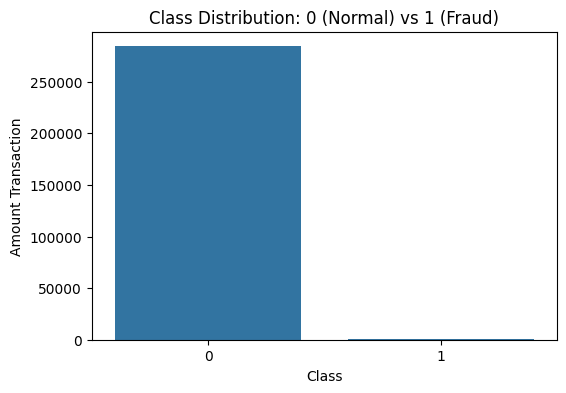

In [5]:
# Class target distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Class')
plt.title('Class Distribution: 0 (Normal) vs 1 (Fraud)')
plt.xlabel('Class')
plt.ylabel('Amount Transaction')
plt.show()

In [6]:
# Fraud Ratio
fraud_ratio = df['Class'].mean() * 100
print(f"Fraud Transaction amount: {fraud_ratio:.4f}%")

Fraud Transaction amount: 0.1727%


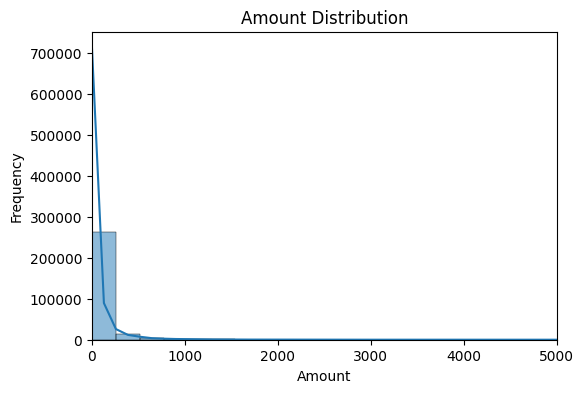

In [7]:
# Distribusi Amount
plt.figure(figsize=(6,4))
sns.histplot(df['Amount'], bins=100, kde=True)
plt.title('Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.xlim(0, 5000)  # So that outliers don't skew the results
plt.show()

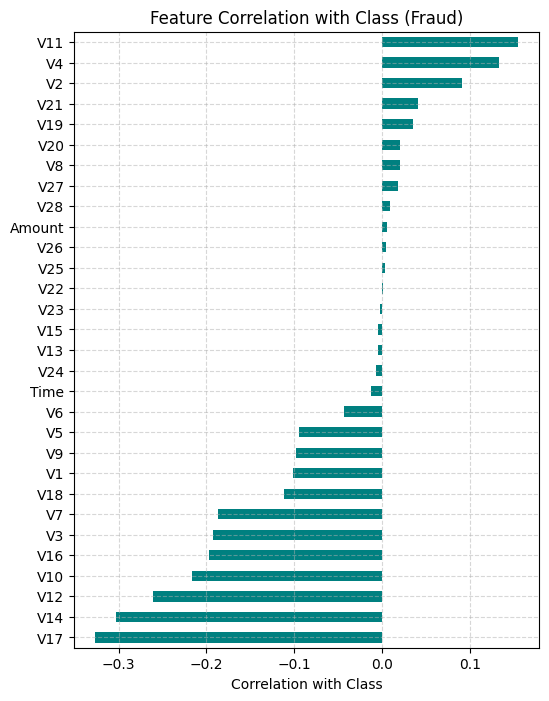

In [8]:
# Correlation of Class with other features
correlations = df.corr()['Class'].drop('Class').sort_values()
plt.figure(figsize=(6, 8))
correlations.plot(kind='barh', color='teal')
plt.title('Feature Correlation with Class (Fraud)')
plt.xlabel('Correlation with Class')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


✅ Why a Correlation Bar Chart is More Suitable
We want to know the linear relationship between each feature and the Class label. Because:

* All features V1 to V28 are already the standardized results of PCA (Principal Component Analysis).
* We want to find out which features are positively or negatively correlated with fraud.
* Pearson correlation (via df.corr()) numerically shows that relationship.

# 3. Preprocessing & Splitting Data

We will do the following:

* Separate features and target (X and y).
* Split the data into training and testing sets.
* Scale the Amount feature (since other features were scaled from the beginning via PCA).

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# 2. Scale the 'Amount' column because other features are already PCA results
X_scaled = X.copy()
scaler = StandardScaler()
X_scaled['Amount'] = scaler.fit_transform(X[['Amount']])

# 3. Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Check data sizes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Positive class in train: {sum(y_train)}")
print(f"Positive class in test: {sum(y_test)}")

X_train shape: (227845, 30)
X_test shape: (56962, 30)
Positive class in train: 394
Positive class in test: 98


# 4. Baseline Model

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Initialize the model
baseline_model = RandomForestClassifier(random_state=42)

# 2. Train the model on the original data (without imbalance adjustment)
baseline_model.fit(X_train, y_train)

# 3. Predict
y_pred = baseline_model.predict(X_test)

# 4. Evaluate
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\n🔥 ROC AUC Score:", roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:, 1]))

📊 Confusion Matrix:
[[56859     5]
 [   18    80]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962


🔥 ROC AUC Score: 0.9630272515590367


# 5. Imbalanced Data

## SMOTE

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 2. Train the model again
model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

# 3. Predict
y_pred_smote = model_smote.predict(X_test)

# 4. Evaluate
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_smote))
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_smote))
print("\n🔥 ROC AUC Score:", roc_auc_score(y_test, model_smote.predict_proba(X_test)[:, 1]))

📊 Confusion Matrix:
[[56847    17]
 [   17    81]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962


🔥 ROC AUC Score: 0.9691768150000575


## Random Undersampling

In [13]:
from imblearn.under_sampling import RandomUnderSampler

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_res_rus, y_res_rus = rus.fit_resample(X_train, y_train)

# Check new distribution
print("Distribution after Undersampling:", y_res_rus.value_counts())

# Train the same model (Random Forest)
model_rus = RandomForestClassifier(random_state=42)
model_rus.fit(X_res_rus, y_res_rus)

# Predict on the test set
y_pred_rus = model_rus.predict(X_test)
y_prob_rus = model_rus.predict_proba(X_test)[:, 1]

# Evaluate
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rus))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rus))

roc_auc_rus = roc_auc_score(y_test, y_prob_rus)
print(f"\n🔥 ROC AUC Score: {roc_auc_rus}")

Distribution after Undersampling: Class
0    394
1    394
Name: count, dtype: int64
📊 Confusion Matrix:
[[54827  2037]
 [    8    90]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962


🔥 ROC AUC Score: 0.9776977722715422


## class weighting (Random Forest)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Membuat model dengan penyesuaian class_weight
rf_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)

# Latih model
rf_weighted.fit(X_train, y_train)

# Prediksi
y_pred_weighted = rf_weighted.predict(X_test)

# Evaluasi
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_weighted))
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_weighted))
print("\n🔥 ROC AUC Score:", roc_auc_score(y_test, y_pred_weighted))


📊 Confusion Matrix:
[[56861     3]
 [   25    73]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962


🔥 ROC AUC Score: 0.8724226008636431


## Summary on handling imbalance data

based on the result, SMOTE Metode is the best result regarding baseline model

# 6. Advance modelling

## Random Forest (with SMOTE data)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("🔥 ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

📊 Confusion Matrix:
[[56847    17]
 [   17    81]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

🔥 ROC AUC Score: 0.9691768150000575


## XGBoost (with SMOTE data)

In [20]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("🔥 ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

📊 Confusion Matrix:
[[56839    25]
 [   13    85]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.87      0.82        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

🔥 ROC AUC Score: 0.9691768150000575


## LightGBM Evaluation (with SMOTE data)

In [21]:
from lightgbm import LGBMClassifier

# Model LightGBM
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_smote, y_train_smote)
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

print("🔥 ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
📊 Confusion Matrix:
[[56809    55]
 [   14    84]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.60      0.86      0.71        98

    accuracy                           1.00     56962
   macro avg       0.80      0.93      0.85     56962
weighted avg       1.00      1.00      1.00     56962

🔥 ROC AUC Score: 0.9691768150000575


## Interpretation:
🟢 Random Forest
Catches quite a few thieves (recall 83%)
But also rarely falsely accuses innocent people (high precision)
Overall score is very stable.
✅ Suitable if you want the most balanced model.

🔵 XGBoost
More aggressive at catching thieves (recall 87%)
But tends to make slightly more false accusations (precision drops to 77%).
✅ Suitable if you want to prioritize fraud detection, even with a slightly higher number of false alarms.

🟡 LightGBM
Very aggressive at catching thieves (recall 86%)
But very often falsely accuses innocent people of being thieves (precision only 60%).
⚠️ Suitable if you really want to avoid missing any fraud, and false alarms are not a big problem (e.g., can be manually checked by an investigation team).

# 7. Hyperparameter Tuning

## optuna with random forest

In [26]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# Use SMOTE data because it gave the most stable results
X_train_tune = X_train_smote
y_train_tune = y_train_smote

def objective(trial):
    # Automatically tried by Optuna
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    model = RandomForestClassifier(**params, random_state=42)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # We use ROC AUC to evaluate each combination
    score = cross_val_score(model, X_train_tune, y_train_tune, cv=cv, scoring='roc_auc', n_jobs=-1)
    return score.mean()

# Run tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=600)  # For example, maximum 30 trials or 10 minutes

[I 2025-04-21 16:08:04,117] A new study created in memory with name: no-name-abce97e6-4084-4fed-9e23-31764b5c87ce
[I 2025-04-21 16:20:33,053] Trial 0 finished with value: 0.9964393590060744 and parameters: {'n_estimators': 198, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9964393590060744.


In [27]:
print("🔥 Best ROC-AUC:", study.best_value)
print("✅ Best Params:", study.best_params)

# Save the best model
best_rf = RandomForestClassifier(**study.best_params, random_state=42)
best_rf.fit(X_train_tune, y_train_tune)

# Evaluate on the test data
y_pred_best_rf = best_rf.predict(X_test)
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_best_rf))
print("🔥 ROC AUC Score:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]))

🔥 Best ROC-AUC: 0.9964393590060744
✅ Best Params: {'n_estimators': 198, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True}
📊 Confusion Matrix:
[[56530   334]
 [   11    87]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.21      0.89      0.34        98

    accuracy                           0.99     56962
   macro avg       0.60      0.94      0.67     56962
weighted avg       1.00      0.99      1.00     56962

🔥 ROC AUC Score: 0.975548175094461
